FIP200 LD and inclusion quantification  
- Exclude cells with faint inclusions that don’t segment.  
- %SA overlap between LDs and synuclein inclusions.  
- number of inclusions  
- surface area of inclusions  
- SA and number of LDs in inclusions and outside inclusions  
- analyze LDs only in green cells (Cellpose)  
- We imaged only cells that contain inclusions.  

Import Libraries

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
from skimage.filters import unsharp_mask
model = models.Cellpose(model_type='cyto')
# model = models.Cellpose(model_type='nuclei')

Define Sub Functions

In [ ]:
def show_image(image):
    io.imshow(image, cmap='gray')
    plt.show()

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for cell segmentation and inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    # increase image contrast
    
    # confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    
    return confocal_img

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1


def increase_contrast(image):
    """Increase the contrast of the image."""
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

def segment_cells(green_channel):
    """Segment cells in the green channel."""
    mean_intensity = np.mean(green_channel[green_channel > 0.2])
    print("Mean Intensity: ", mean_intensity)
    green_channel_remove_inclusions = np.where(green_channel < 0.6, green_channel, mean_intensity) # remove inclusions
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5) # blur
    
    # normalize
    green_channel_remove_inclusions = (green_channel_remove_inclusions - np.min(green_channel_remove_inclusions)) / ((np.max(green_channel_remove_inclusions) - np.min(green_channel_remove_inclusions)))
    show_image(green_channel_remove_inclusions)

    # Detect cells in the green channel
    masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=300, channels=[0, 0])
    labeled_cells = label(masks)
    return labeled_cells

def extract_inclusions(green_channel,mask):
    applied_mask_blurred = gaussian(green_channel, sigma=1) * mask
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0] # filter out 0
    
    # normalize 
    applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / ((np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background)))

    # calculate statistics
    mean_intensity = np.mean(applied_mask_eliminate_background)
    median_intensity = np.median(applied_mask_eliminate_background)
    q1 = np.percentile(applied_mask_eliminate_background, 25)
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
    
    applied_mask = green_channel * mask
    # 0.5 is an empirical value that seems to work well
    if q3 < 0.5 and len(bin_edges) > 20:
        # the population is skewed to the left, indicating that there are inclusions
        threshold = max(threshold_otsu(applied_mask),0.5) # use otsu thresholding to find the threshold
    elif q3 >= 0.7:
        # definitely no inclusions
        threshold = 1
    else:
        # probably no inclusions, but not sure, so we set a very high threshold in case there are inclusions
        threshold = 0.999
    
    inclusions = applied_mask > threshold # apply the threshold

    inclusions = remove_small_objects(inclusions, min_size=10) # remove small objects
    inclusions = inclusions ^ remove_small_objects(inclusions, min_size=3000) # remove large objects


    print("Threshold: ", threshold)
    print("Bin count", len(bin_edges))

    plt.hist(applied_mask_eliminate_background, bins='fd')  
    plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_intensity:.2f}')
    plt.axvline(median_intensity, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_intensity:.2f}')
    plt.axvline(q1, color='blue', linestyle='dashed', linewidth=2, label=f'Q1: {q1:.2f}')
    plt.axvline(q3, color='purple', linestyle='dashed', linewidth=2, label=f'Q3: {q3:.2f}')
    plt.legend()
    plt.title("Intensity histogram")
    plt.show()

    return inclusions


In [ ]:
def analyze_image(image_path, basename):

    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)

    # Separate the channels
    red_channel = image_squeezed[0, :, :]
    green_channel = image_squeezed[1, :, :]

    threshold_red = threshold_otsu(gaussian(red_channel)) + 0.1
    red_channel_thresholded = gaussian(red_channel) > threshold_red

    # TODO: use cellpose for red channel

    # print("Red Channel")
    # show_image(red_channel_thresholded)

    green_channel = preprocess_green_channel(green_channel)
    print("Green Channel")
    show_image(green_channel)

    labeled_cells = segment_cells(green_channel)
    
    print("Segmented Cells")
    show_image(labeled_cells)


    # Initialize lists to store results
    num_inclusions = []
    total_inclusion_areas = []


    number_of_ld_in_inclusions_list = []
    area_of_ld_in_inclusions_list = []
    number_of_ld_outside_inclusions_list = []
    area_of_ld_outside_inclusions_list = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        
        
        mask = labeled_cells == cell.label
        
        inclusions = extract_inclusions(green_channel, mask)

        show_image(inclusions)
        dilated_inclusions = binary_dilation(inclusions, disk(5)) # dilate the inclusions
        inclusions_labeled = label(inclusions)

        dilated_inclusions_labeled = label(dilated_inclusions)
        num_inclusions.append(len(np.unique(dilated_inclusions_labeled)) - 1)
        
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled)]
        inclusion_areas = np.array(inclusion_areas)
        print("Inclusion Areas: ", inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        
        # if len(inclusion_areas) > 0:

        

        ld_cell = red_channel_thresholded * mask # find the lipid droplets in the cell
        ld_cell_labeled = label(ld_cell) # label the lipid droplets in the cell
        number_of_ld_in_inclusions = 0
        area_of_ld_in_inclusions = 0
        number_of_ld_outside_inclusions = 0
        area_of_ld_outside_inclusions = 0
        
        for ld in regionprops(ld_cell_labeled):
            if ld.area < 10:
                continue
            ld_image = ld_cell_labeled == ld.label
            # show_image(ld_image)
            overlap = inclusions_labeled * ld_image
            if np.sum(overlap) > 0:
                number_of_ld_in_inclusions += 1
                area_of_ld_in_inclusions += ld.area
            else:
                number_of_ld_outside_inclusions += 1
                area_of_ld_outside_inclusions += ld.area
        if len(inclusion_areas) == 0:
            number_of_ld_in_inclusions = 0
            area_of_ld_in_inclusions = 0

        number_of_ld_in_inclusions_list.append(number_of_ld_in_inclusions)
        area_of_ld_in_inclusions_list.append(area_of_ld_in_inclusions)
        number_of_ld_outside_inclusions_list.append(number_of_ld_outside_inclusions)
        area_of_ld_outside_inclusions_list.append(area_of_ld_outside_inclusions)
        total_inclusion_areas.append(total_inclusion_area)
    
    # analysis by image
    df1 = pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Area_of_Inclusions": [np.sum(total_inclusion_areas)],
        "Number_of_LD_in_Inclusions": [np.sum(number_of_ld_in_inclusions_list)],
        "Area_of_LD_in_Inclusions": [np.sum(area_of_ld_in_inclusions_list)],
        "Number_of_LD_outside_Inclusions": [np.sum(number_of_ld_outside_inclusions_list)],
        "Area_of_LD_outside_Inclusions": [np.sum(area_of_ld_outside_inclusions_list)],
    })
    
   
    return df1

In [28]:
def analyze_all_images(image_folder, images=None):
    # images is the list of images to analyze, if set to None, analyze all images
    all_data_1 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(well_image)
            if images is not None and well_image not in images:
                continue

            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]


            
            df1 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image.xlsx", index=False)


Define Main Function

In [29]:
folders = ['11725_lipidDroplets_FIP200','12425_LipidDroplets_FIP200','13125_LipidDroplets_FIP200']


1K_FIP200_LT_noOA_01.czi
1K_FIP200_LT_noOA_02.czi
1K_FIP200_LT_noOA_03.czi
1K_FIP200_LT_noOA_04.czi
1K_FIP200_LT_noOA_05.czi
1K_FIP200_LT_noOA_06.czi
1K_FIP200_LT_OA_01.czi
1K_FIP200_LT_OA_02.czi
1K_FIP200_LT_OA_03.czi
1K_FIP200_LT_OA_04.czi
1K_FIP200_LT_OA_05.czi
1K_FIP200_LT_OA_06.czi
1K_SCR_LT_noOA_01.czi
1K_SCR_LT_noOA_02.czi
1K_SCR_LT_noOA_03.czi
1K_SCR_LT_noOA_04.czi
1K_SCR_LT_noOA_05.czi
1K_SCR_LT_noOA_06.czi
1K_SCR_LT_OA_01.czi
1K_SCR_LT_OA_02.czi
1K_SCR_LT_OA_03.czi
1K_SCR_LT_OA_04.czi
1K_SCR_LT_OA_05.czi
1K_SCR_LT_OA_06.czi
3K_FIP200_LT_noOA_01.czi
3K_FIP200_LT_noOA_02.czi
3K_FIP200_LT_noOA_03.czi
3K_FIP200_LT_noOA_04.czi
3K_FIP200_LT_noOA_05.czi
3K_FIP200_LT_noOA_06.czi
3K_FIP200_LT_OA_01.czi
3K_FIP200_LT_OA_02.czi
3K_FIP200_LT_OA_03.czi
3K_FIP200_LT_OA_04.czi
3K_FIP200_LT_OA_05.czi
3K_FIP200_LT_OA_06.czi
3K_SCR_LT_noOA_01.czi
3K_SCR_LT_noOA_02.czi
3K_SCR_LT_noOA_03.czi
3K_SCR_LT_noOA_04.czi
3K_SCR_LT_noOA_05.czi
3K_SCR_LT_noOA_06.czi
3K_SCR_LT_OA_01.czi
3K_SCR_LT_OA_02.czi


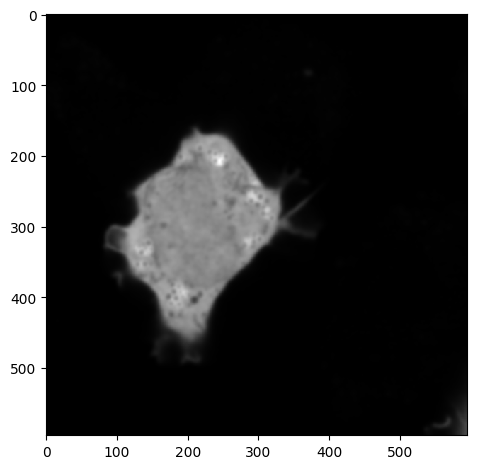

Mean Intensity:  0.5323900006946151


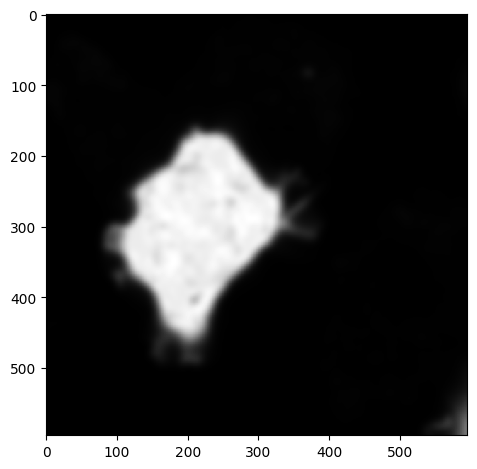

Segmented Cells


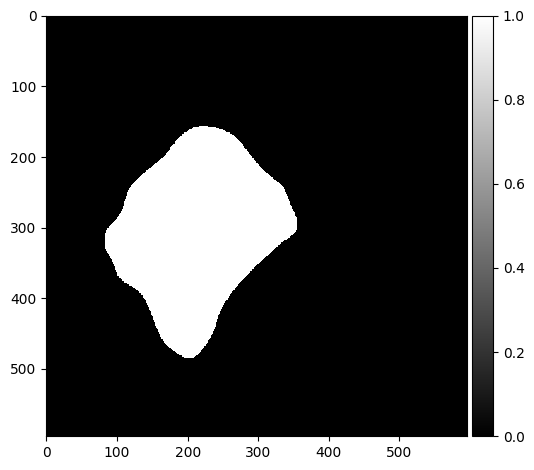

Threshold:  0.999
Bin count 75


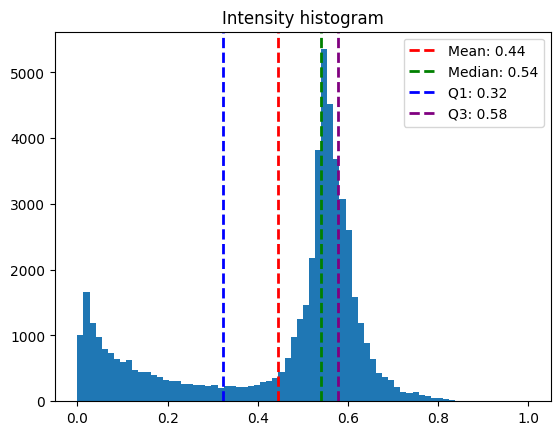

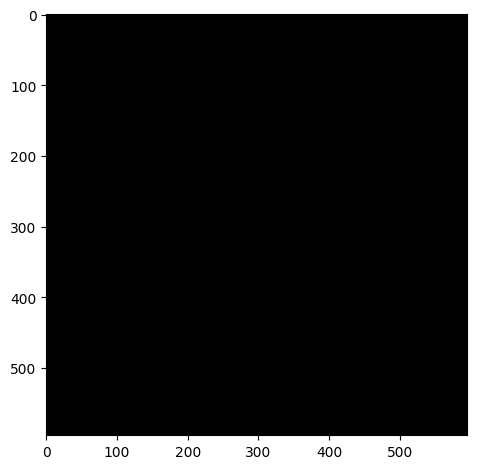

Inclusion Areas:  []
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_FIP200_LT_OA_03.czi
WT_FIP200_LT_OA_04.czi
WT_FIP200_LT_OA_05.czi
WT_FIP200_LT_OA_06.czi
WT_SCR_LT_noOA_01.czi
WT_SCR_LT_noOA_02.czi
WT_SCR_LT_noOA_03.czi
WT_SCR_LT_noOA_04.czi
WT_SCR_LT_noOA_05.czi
WT_SCR_LT_noOA_06.czi
WT_SCR_LT_OA_01.czi
WT_SCR_LT_OA_02.czi
WT_SCR_LT_OA_03.czi
WT_SCR_LT_OA_04.czi
WT_SCR_LT_OA_05.czi
WT_SCR_LT_OA_06.czi


PermissionError: [Errno 13] Permission denied: '11725__analysis_by_image.xlsx'

In [ ]:

for folder in folders:
    analyze_all_images(folder)
